In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import plotly.express as px

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

In [2]:
df = pd.read_csv("NVDA.csv")
df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)

In [25]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,MA50,MA200
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200,NaN,NaN
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000,NaN,NaN
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200,NaN,NaN
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000,NaN,NaN
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6111,2024-04-18,849.700012,861.900024,824.020020,846.710022,846.710022,44726000,839.252000,567.20780
6112,2024-04-19,831.500000,843.239990,756.059998,762.000000,762.000000,87190500,840.472200,568.90195
6113,2024-04-22,781.039978,800.729980,764.000000,795.179993,795.179993,59634100,842.447600,570.77270
6114,2024-04-23,807.690002,827.690002,802.640015,824.229980,824.229980,43855900,844.505599,572.76870


In [4]:
def check_df(df):
    print("##################### Shape #####################")
    print(df.shape)
    print("\n##################### Columns #####################")
    print(df.columns)
    print("\n##################### Info #####################")
    df.info()
    print("##################### Types #####################")
    print(df.dtypes)
    print("##################### Head #####################")
    print(df.head())
    print("##################### Tail #####################")
    print(df.tail())
    print("##################### NA #####################")
    print(df.isnull().sum())

check_df(df)

##################### Shape #####################
(6116, 7)

##################### Columns #####################
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6116 non-null   datetime64[ns]
 1   Open       6116 non-null   float64       
 2   High       6116 non-null   float64       
 3   Low        6116 non-null   float64       
 4   Close      6116 non-null   float64       
 5   Adj Close  6116 non-null   float64       
 6   Volume     6116 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 334.6 KB
##################### Types #####################
Date         datetime64[ns]
Open                float64
High                float64
Low             

In [5]:
## data statistics ##
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,6116,6116.000000,6116.000000,6116.000000,6116.000000,6116.000000,6.116000e+03
mean,2012-02-28 11:27:16.363636480,53.052266,54.017201,52.031700,53.064741,52.794253,6.221933e+07
min,2000-01-03 00:00:00,0.608333,0.656667,0.600000,0.614167,0.563377,4.564400e+06
25%,2006-02-01 18:00:00,2.959688,3.027500,2.875000,2.950391,2.707880,3.615840e+07
50%,2012-02-28 12:00:00,4.683750,4.747500,4.608750,4.682500,4.389289,5.206235e+07
75%,2018-03-27 06:00:00,42.101873,42.645625,41.500000,42.102499,41.741090,7.465490e+07
max,2024-04-24 00:00:00,958.510010,974.000000,935.099976,950.020020,950.020020,9.230856e+08
std,NaN,121.267334,123.423982,118.835114,121.183234,121.214864,4.316714e+07


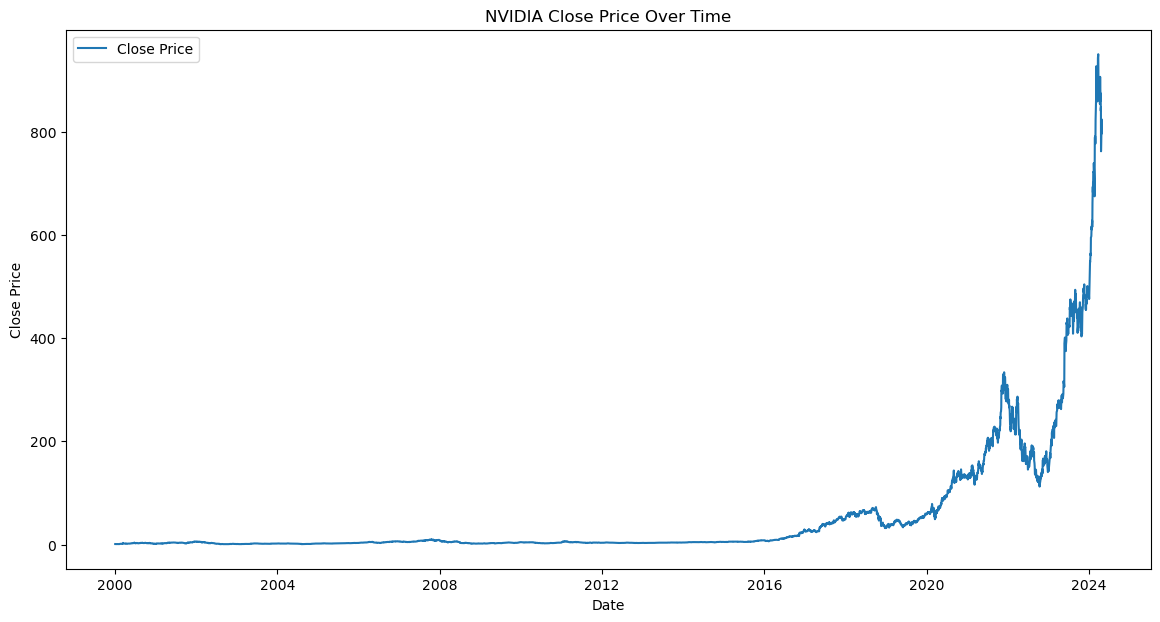

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('NVIDIA Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [7]:
# Hareketli Ortalama

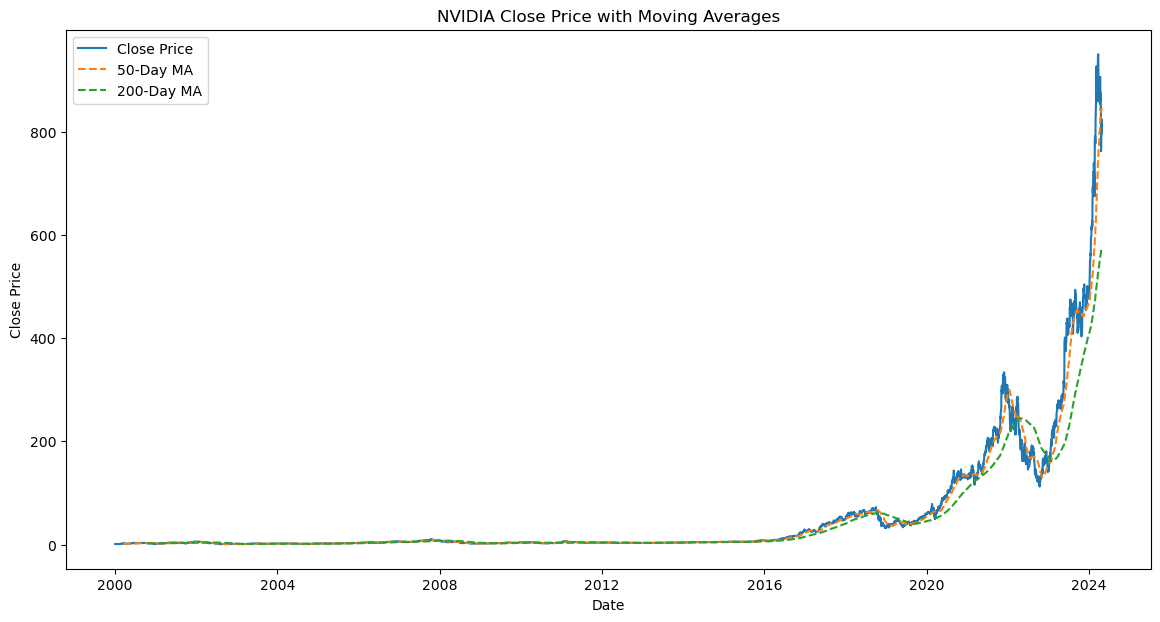

In [8]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', linestyle='--')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', linestyle='--')
plt.title('NVIDIA Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [9]:
#### LSBT İLE HİSSE FİYATI TAHMİNİ ####

In [10]:
#Veri Hazırlığı

In [11]:
# Sadece kapanış fiyatını kullanacağız
data = df['Close'].values.reshape(-1, 1)

# Veriyi normalize edelim
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# LSTM modeline uygun şekilde veri setini hazırlayalım
train_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:train_data_len, :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Veriyi numpy array'e çevirelim
X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM girişine uygun şekil verelim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

array([0.00100436, 0.00099476, 0.00120699, ..., 0.03785086, 0.03839331,
       0.03744008])

In [12]:
#Model Eğitimi

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Modeli tanımlayalım
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Modeli derleyelim
model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitelim
model.fit(X_train, y_train, batch_size=1, epochs=1)


C:\Users\burak.demir\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4833/4833 ━━━━━━━━━━━━━━━━━━━━ 86s 17ms/step - loss: 2.1183e-05


In [14]:
#Tahmin

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


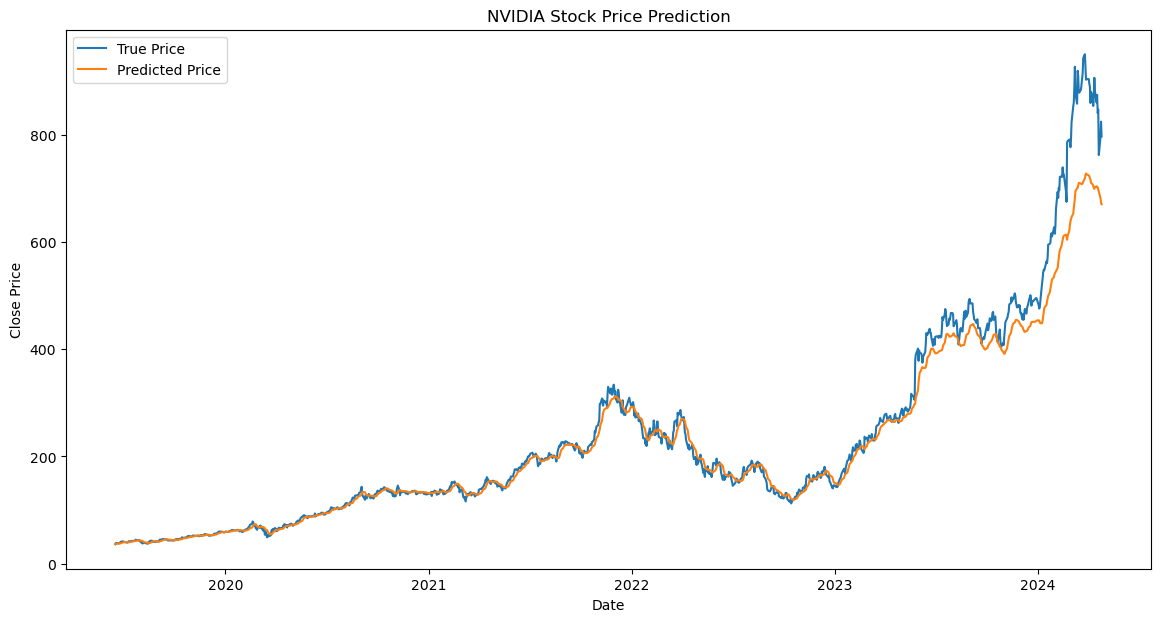

In [15]:
# Test veri seti oluşturuluyor
test_data = scaled_data[train_data_len - 60:, :]
X_test = []
y_test = data[train_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# Veriyi numpy array'e çevirelim
X_test = np.array(X_test)

# LSTM girişine uygun şekil verelim
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Tahmin yapalım
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Tahmin ve gerçek değerleri karşılaştıralım
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][train_data_len:], y_test, label='True Price')
plt.plot(df['Date'][train_data_len:], predictions, label='Predicted Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [35]:
#### Univarite Variable

def column_detection(dataframe: pd.DataFrame, cat_th: int = 10, car_th: int = 20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                       df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                    df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print("\n##################### Categoric #####################")
    print(cat_cols)
    print("\n##################### Numeric #####################")
    print(num_cols)
    print("\n##################### Categoric But Cardinal #####################")
    print(cat_but_car)
    print("\n##################### Numeric But Categoric #####################")
    print(num_but_cat)
    print("\n##################### Columns Overview #####################")
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [36]:
cat_cols, num_cols, cat_but_car, num_but_cat = column_detection(df)


##################### Categoric #####################
[]

##################### Numeric #####################
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA50', 'MA200']

##################### Categoric But Cardinal #####################
[]

##################### Numeric But Categoric #####################
[]

##################### Columns Overview #####################
Observations: 6116
Variables: 9
cat_cols: 0
num_cols: 9
cat_but_car: 0
num_but_cat: 0


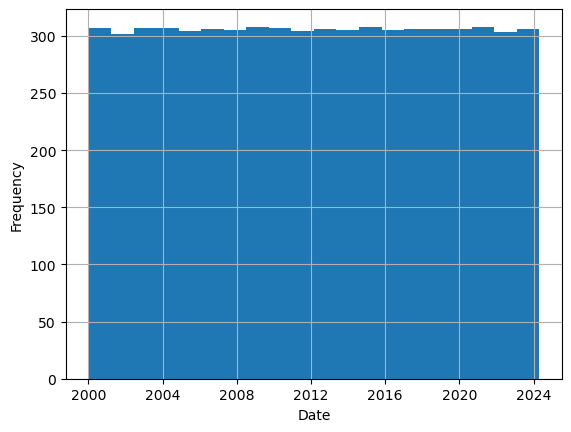

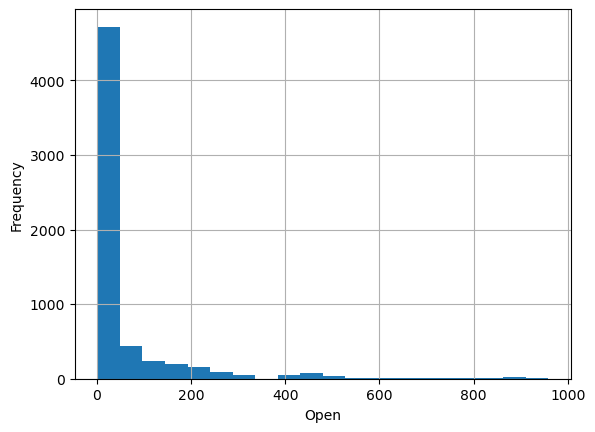

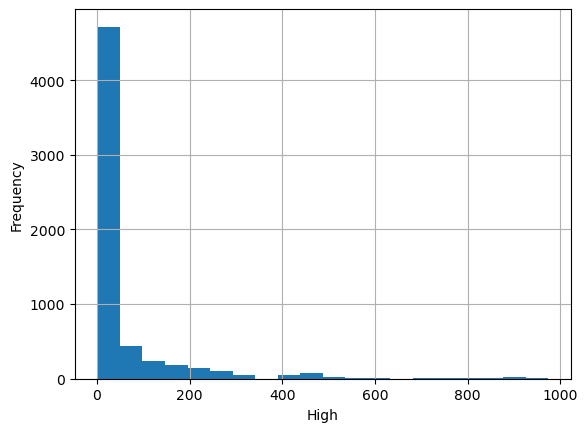

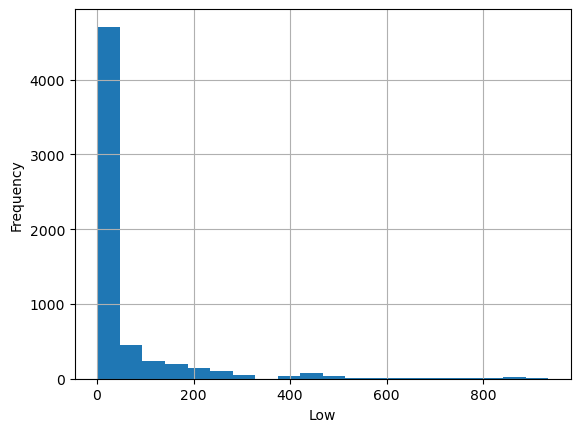

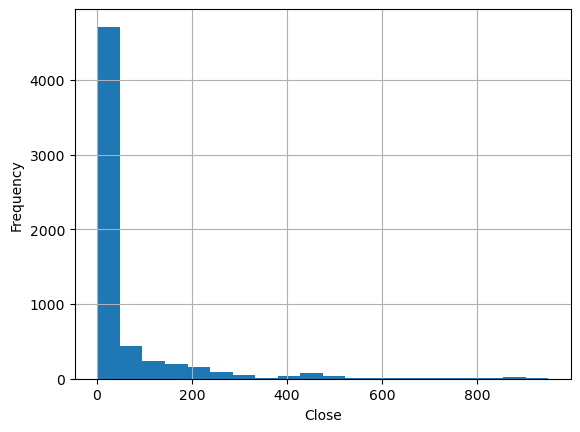

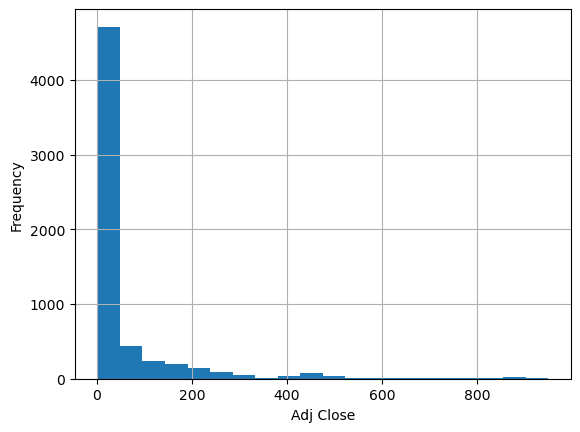

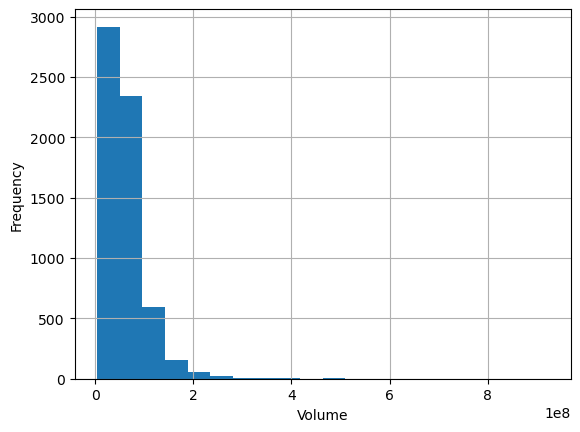

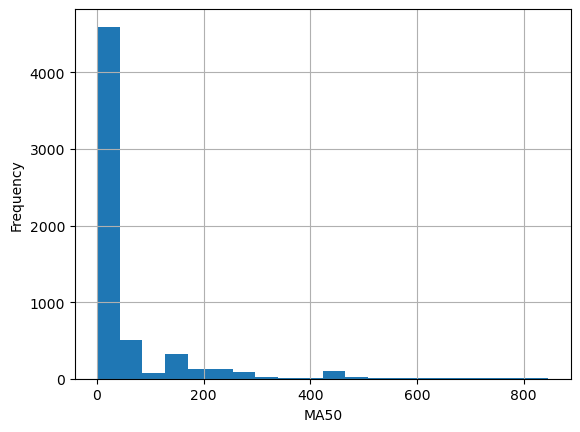

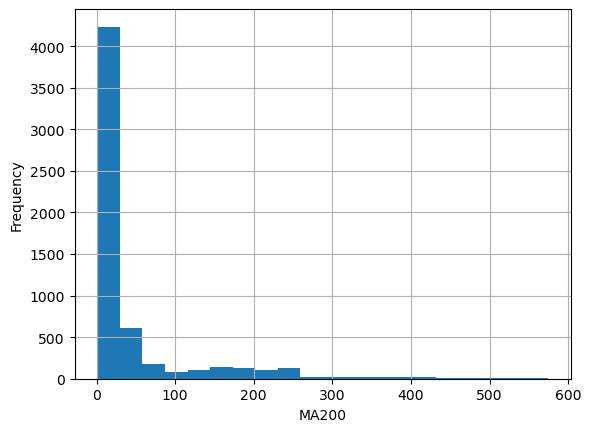

In [37]:
def cat_summary(df, col_name, plot=True):
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))

    if plot:
        sns.countplot(x=df[col_name], data=df)
        plt.show(block=True)


for col in cat_cols:
    cat_summary(df, col)


def hist_num_columns_show(df, num_column):
    df[num_column].hist(bins=20)
    plt.xlabel(num_column)
    plt.ylabel("Frequency")
    plt.show(block=True)


for num_col in num_cols:
    hist_num_columns_show(df, num_col)

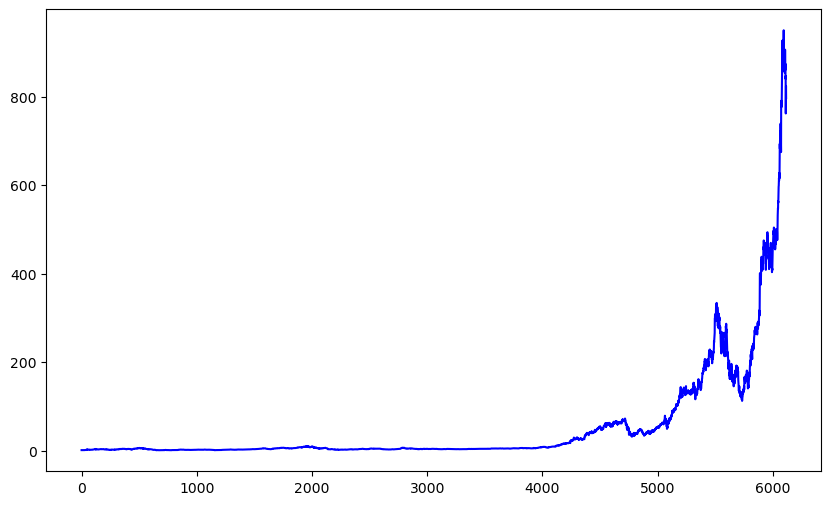

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')

In [39]:
monthvise= df.groupby(df['Date'].dt.strftime('%B'))[['Open','Close','Low','High']].mean()
monthsort= df.groupby(df['Date'].dt.strftime('%B'))[['Open','Close','Low','High']].mean().sort_values(by='Close')
monthvise

,Open,Close,Low,High
Date,,,,
April,66.013187,65.571917,64.464209,67.081862
August,49.447074,49.513534,48.526833,50.350168
December,54.048828,53.953962,53.012579,54.856716
February,64.393898,64.571119,63.110134,65.758041
January,55.028557,55.223957,54.027632,56.132832
July,45.498201,45.532563,44.762818,46.200914
June,44.039314,44.105209,43.304084,44.818446
March,69.060984,69.152373,67.539918,70.561786
May,38.202963,38.301326,37.467343,39.006078


In [40]:
monthsort

,Open,Close,Low,High
Date,,,,
May,38.202963,38.301326,37.467343,39.006078
June,44.039314,44.105209,43.304084,44.818446
July,45.498201,45.532563,44.762818,46.200914
October,47.222969,47.255780,46.411889,48.044548
September,48.433340,48.304540,47.557102,49.131510
August,49.447074,49.513534,48.526833,50.350168
December,54.048828,53.953962,53.012579,54.856716
November,54.872977,54.922520,53.850511,55.876140
January,55.028557,55.223957,54.027632,56.132832


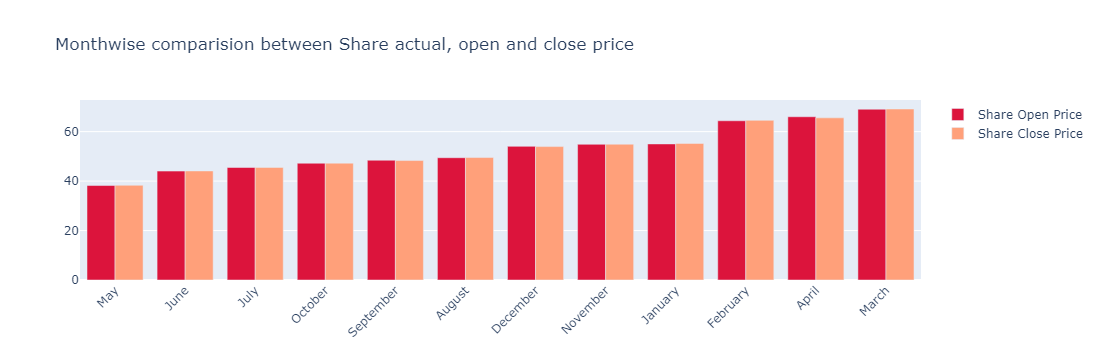

In [41]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthsort.index,
    y=monthsort['Open'],
    name='Share Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthsort.index,
    y=monthsort['Close'],
    name='Share Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Share actual, open and close price')
fig.show()

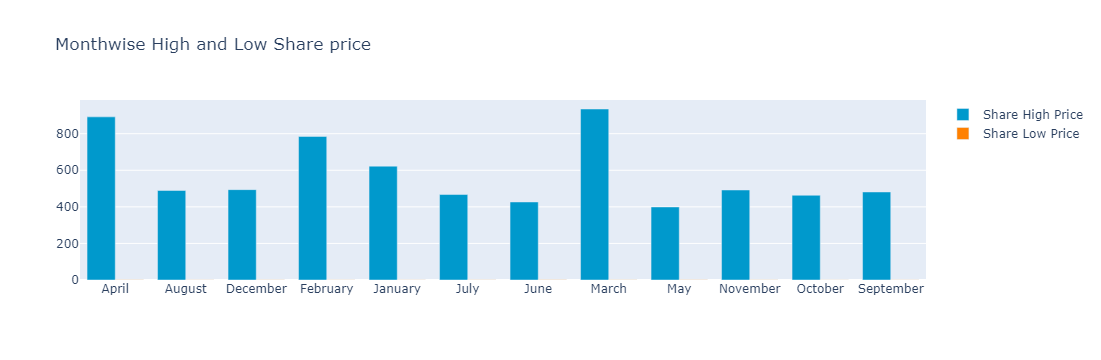

In [42]:
monthvise_high = df.groupby(df['Date'].dt.strftime('%B'))['Low'].max()
monthvise_low = df.groupby(df['Date'].dt.strftime('%B'))['Low'].min()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Share High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Share Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Share price')
fig.show()

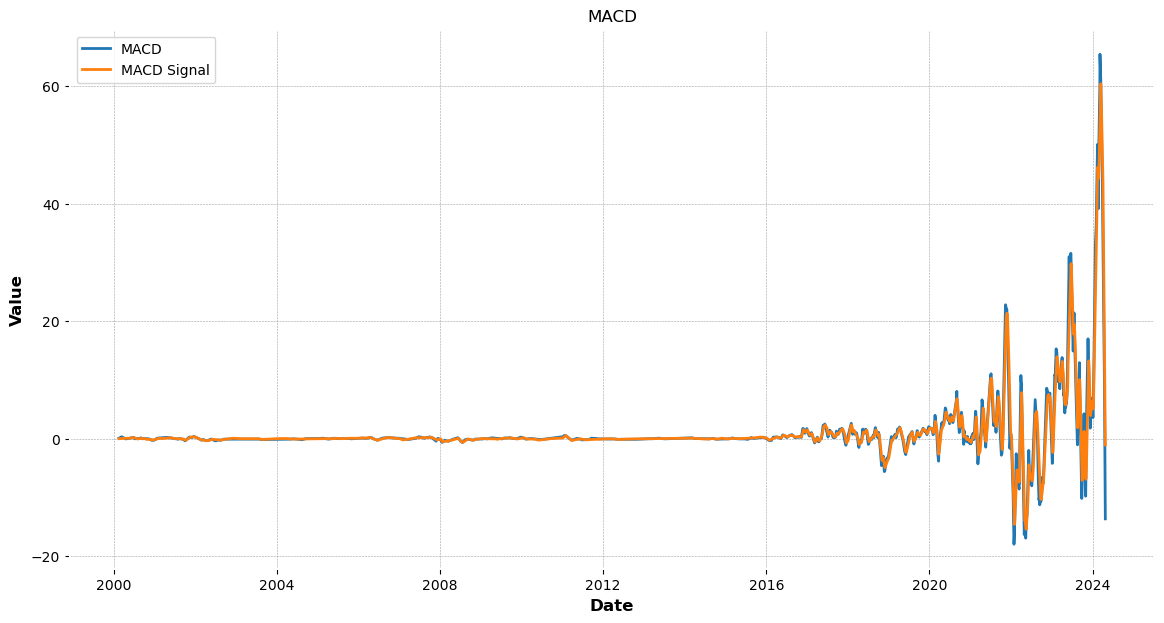

In [48]:
import talib

# Calculate MACD
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Plot MACD
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['MACD'], label='MACD')
plt.plot(df['Date'], df['MACD_Signal'], label='MACD Signal')
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

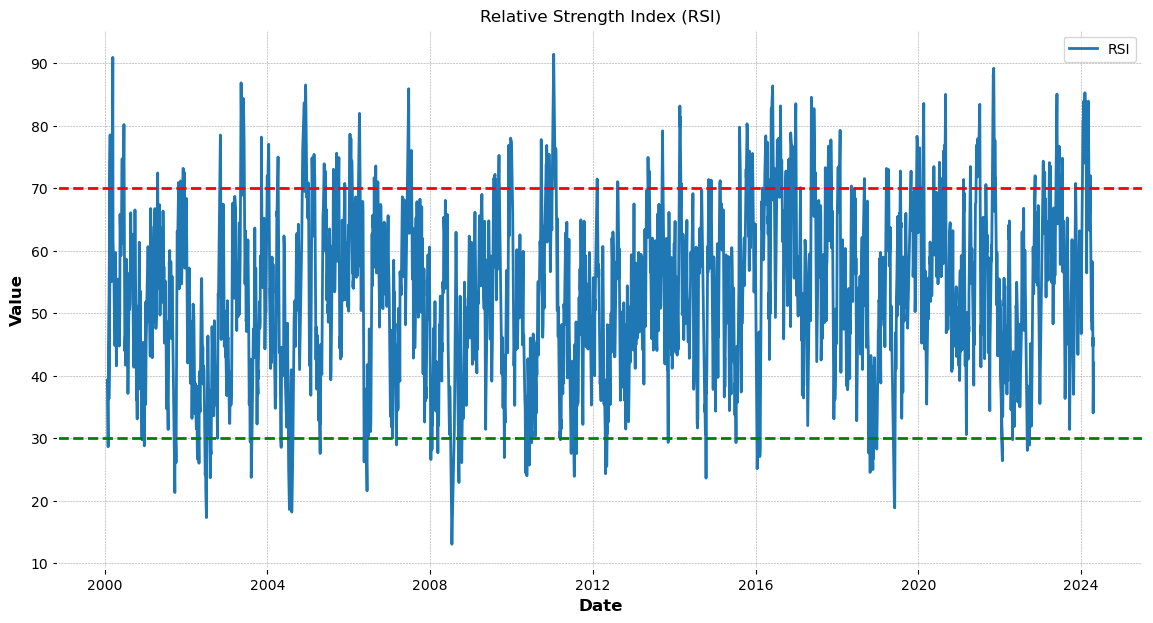

In [49]:
#Calculate RSI
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

# Plot RSI
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['RSI'], label='RSI')
plt.axhline(70, linestyle='--', color='r')
plt.axhline(30, linestyle='--', color='g')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

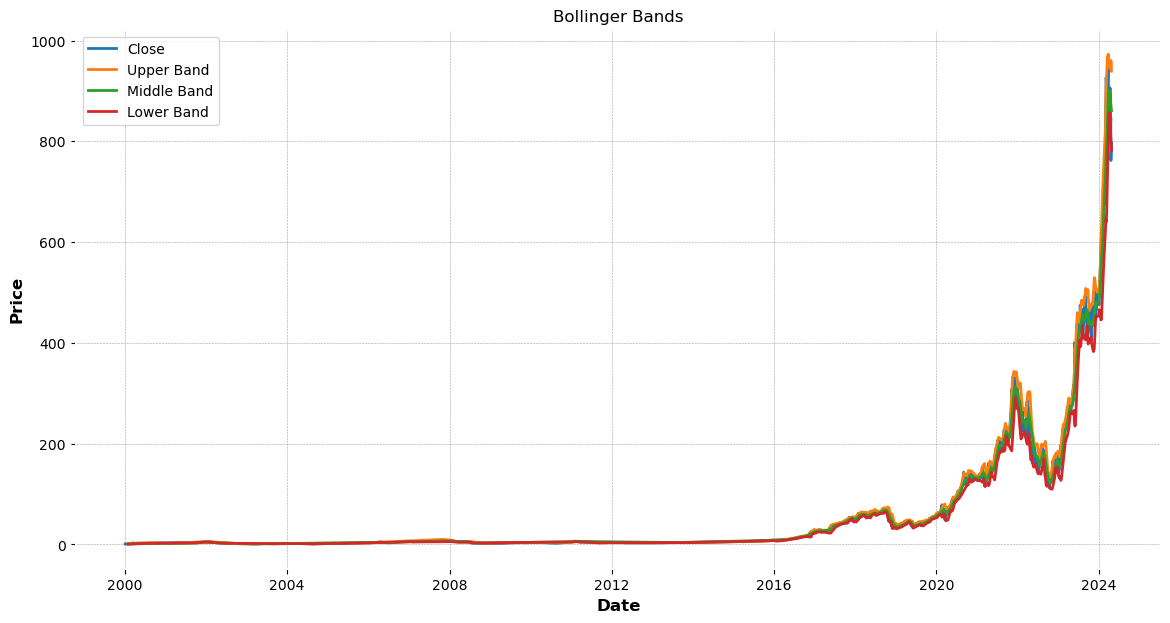

In [50]:
# Calculate Bollinger Bands
df['Upper_Band'], df['Middle_Band'], df['Lower_Band'] = talib.BBANDS(df['Close'], timeperiod=20)

# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['Upper_Band'], label='Upper Band')
plt.plot(df['Date'], df['Middle_Band'], label='Middle Band')
plt.plot(df['Date'], df['Lower_Band'], label='Lower Band')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(df['Close'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=30)
print(forecast)

6116    795.956563
6117    793.012623
6118    795.215693
6119    797.521594
6120    794.690847
6121    794.568055
6122    794.720980
6123    794.819422
6124    794.957052
6125    794.701696
6126    794.694120
6127    794.739554
6128    794.737231
6129    794.741111
6130    794.720963
6131    794.721203
6132    794.727197
6133    794.725871
6134    794.725423
6135    794.724093
6136    794.724227
6137    794.724830
6138    794.724612
6139    794.724511
6140    794.724450
6141    794.724471
6142    794.724521
6143    794.724494
6144    794.724482
6145    794.724482
Name: predicted_mean, dtype: float64


C:\Users\burak.demir\AppData\Local\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




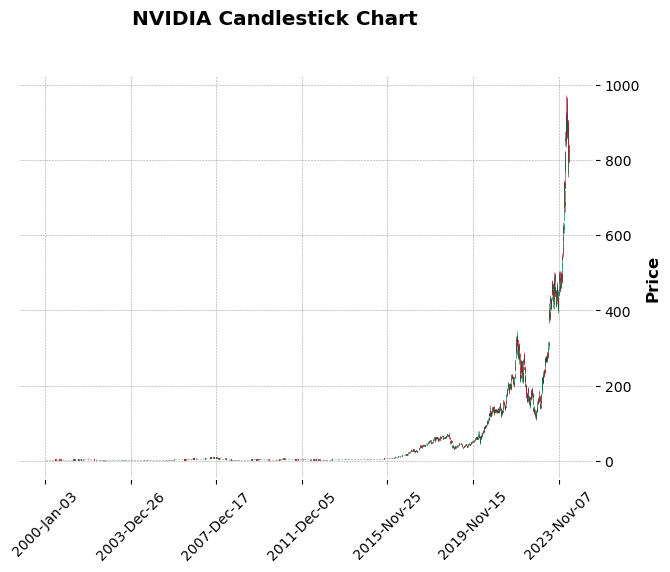

In [46]:
import mplfinance as mpf

# Convert DataFrame to a format suitable for mplfinance
df_for_candlestick = df[['Date', 'Open', 'High', 'Low', 'Close']].copy()
df_for_candlestick.set_index('Date', inplace=True)

# Plot candlestick chart
mpf.plot(df_for_candlestick, type='candle', style='charles', title='NVIDIA Candlestick Chart', ylabel='Price')


In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model = ExponentialSmoothing(df['Close'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=30)
print(forecast)

6116    799.975655
6117    801.540804
6118    803.476046
6119    804.848504
6120    806.735099
6121    808.585922
6122    810.116627
6123    811.517450
6124    813.056650
6125    814.816815
6126    816.510385
6127    818.216651
6128    819.823195
6129    821.388344
6130    823.323586
6131    824.696045
6132    826.582640
6133    828.433463
6134    829.964167
6135    831.364990
6136    832.904190
6137    834.664355
6138    836.357925
6139    838.064191
6140    839.670735
6141    841.235884
6142    843.171126
6143    844.543585
6144    846.430180
6145    848.281003
dtype: float64
